Recapitulating the model: Receptor downregulation and desensitization enhance the information processing ability of signalling receptors

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

The intial EGFR Model

In [63]:
shankaran_model_EGFR = te.loada("""
Ligand_receptor -> Surface_complex; Ligand_receptor*kon
Surface_complex -> Ligand_receptor; Surface_complex*koff

New_receptor -> Ligand_receptor; New_receptor*Vr
Surface_complex -> Internalized_complex; Surface_complex*ke

Ligand_receptor = 5961

kon = 0.097
koff = 0.24

kt = 0.02
ke = 0.15
Vr = kt*Rt 

Rt = 200000
V = 0.0000000004
""")

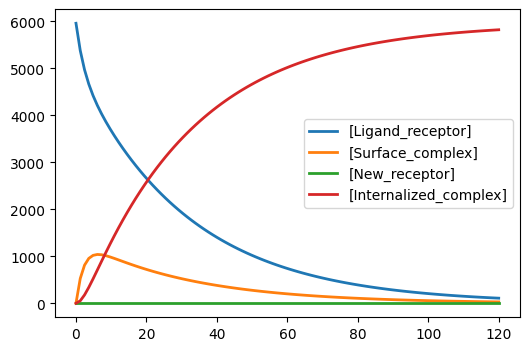

In [64]:
shankaran_model_EGFR.reset()
m = shankaran_model_EGFR.simulate(0, 120, 100)
shankaran_model_EGFR.plot()

Manipulating the EGFR model 

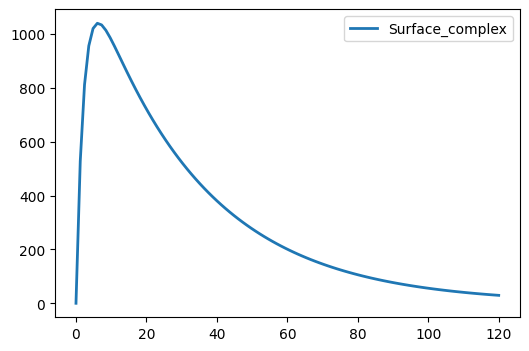

In [65]:
shankaran_model_EGFR.resetToOrigin()
result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Surface_complex'])
shankaran_model_EGFR.plot(result)

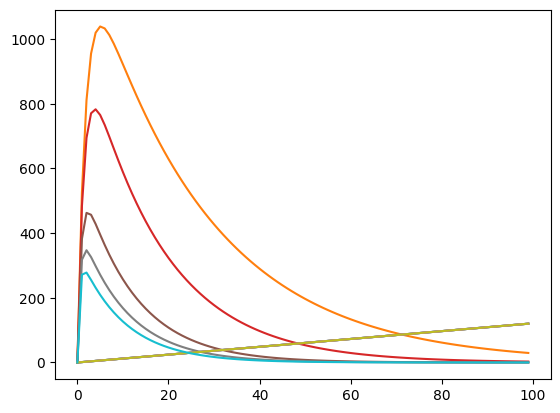

In [78]:
for i in [1,2,5,7.6,10,20]:
    shankaran_model_EGFR.reset()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100)
    plt.plot(result) 
plt.show()

The GPCR Model

In [90]:
shankaran_model_GPCR = te.loada(""" 
Ligand_receptor -> Surface_complex; Ligand_receptor*kon

Surface_complex -> Surface_complex_actived; Surface_complex*kfr
Surface_complex_actived -> Surface_complex; Surface_complex_actived*krr

Surface_complex_actived -> Surface_complex_degraded; Surface_complex_actived*kds

Surface_complex_actived -> Active_G-protein; Surface_complex_actived*ka

Active_Gprotein -> Inactive_Gprotein; Active_Gprotein*ki
Inactive_Gprotein -> Active_Gprotein; Inactive_Gprotein*ka

kon = 84000000
koff = 0.37
kfr = 10
krr = 10
kds = 0.065
ka = 0.0000001
ki = 0.2

Ligand_receptor = 10612
V = 0.0000000004
RT = 55000
GT = 100000
""")

Exception: Antimony: Error in model string, line 9:  syntax error, unexpected '-', expecting '+' or ';'

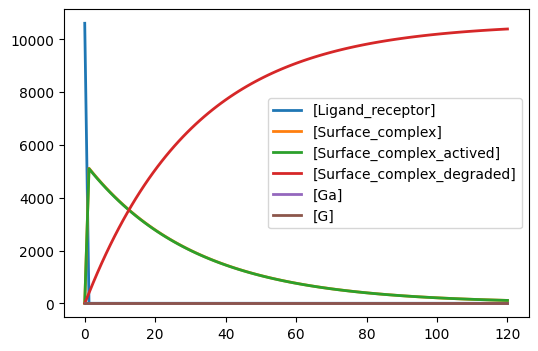

In [59]:
shankaran_model_GPCR.reset()
GPCR_model = shankaran_model_GPCR.simulate(0,120,100)
shankaran_model_GPCR.plot()

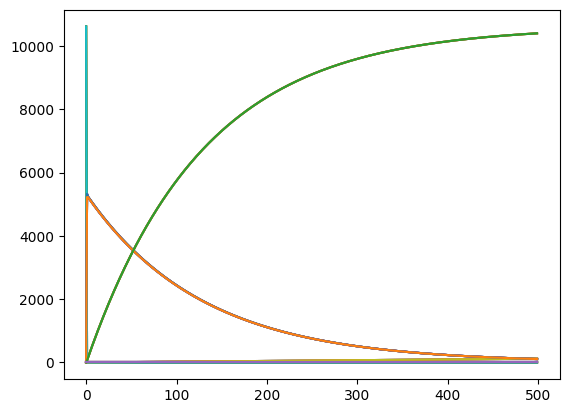

In [83]:
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.reset()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 120, 500,['time','Surface_complex'])
    plt.plot(result) 
plt.show()